In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import sys
from tqdm import tqdm

In [ ]:
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)
    if isinstance(obj,np.ndarray):
        size=obj.nbytes
    elif isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [ ]:
# tu nie ma błędów

def RLE_encode(img):
    og_shape = img.shape
    if len(img.shape) > 1:
        img = img.flatten()

    buffor = np.zeros(np.prod(img.shape)*2, dtype=np.uint32)
    repeats = 1
    buffor_index = 0
    img_index = 0
    while img_index < len(img) - 1:
        symbol = img[img_index]
        while(img[img_index] == img[img_index + 1]):
            repeats += 1
            img_index += 1
            if img_index + 1 == len(img):
                break


        img_index += 1

        buffor[buffor_index] = repeats
        buffor[buffor_index + 1] = symbol
        buffor_index += 2
        repeats = 1

    if img_index == len(img) - 1:
        buffor[buffor_index] = repeats
        buffor[buffor_index + 1] = img[img_index]
        buffor_index += 2

    new_buffor = buffor[:buffor_index]
    return new_buffor, og_shape

#tu też nie ma błędów

def RLE_decode(img_encoded, og_shape):
    #buffer o rozmiarze iloczynu og_shape, czyli tyle ile powinno być ponownie
    decoded_buffor = np.zeros(np.prod(og_shape), dtype=np.uint32)
    encoded_index = 0
    buffor_index = 0

    while(encoded_index < len(img_encoded) - 1):
        repeats = int(img_encoded[encoded_index])
        symbol = img_encoded[encoded_index + 1]

        decoded_buffor[buffor_index : buffor_index + repeats] = symbol
        encoded_index += 2
        buffor_index += repeats

    return decoded_buffor.reshape(og_shape)

[1 1 1 1 2 3 4 5 3 5 5 3 2 4 6 1 5 5 5 1]
[1 1 1 1 2 3 4 5 3 5 5 3 2 4 6 1 5 5 5 1]


In [ ]:
#tu błąd był w składni
def ByteRun_element_repeat(img_slice):
    repeats = 0
    index = 0
    while index + 1 < len(img_slice) and img_slice[index] == img_slice[index + 1]:
        repeats += 1
        index += 1
    return repeats

def ByteRun_element_different(img_slice):
    repeats = 0
    index = 0
    while index + 1 < len(img_slice) and img_slice[index] != img_slice[index + 1]:
        repeats += 1
        index += 1
    return repeats

def ByteRun_encode(img):
    og_shape = img.shape
    if len(img.shape) > 1:
        img = img.flatten()

    buffor = np.zeros(np.prod(img.shape)*2, dtype=np.int32)
    img_index = 0
    buffor_index = 0

    while img_index < len(img) - 1:
        #pakujemy po 128 bajtów
        if img_index + 128 < len(img):
            img_slice = img[img_index: img_index + 128]
        else:
            img_slice = img[img_index: len(img)]


        repeats = ByteRun_element_repeat(img_slice)
        if repeats > 0:
            buffor[buffor_index] = -repeats
            buffor[buffor_index + 1] = img_slice[0]
            buffor_index += 2
            img_index += repeats + 1

        else:
            repeats = ByteRun_element_different(img_slice)
            buffor[buffor_index] = repeats
            buffor[buffor_index + 1: buffor_index + repeats + 2] = img_slice[: repeats + 1]
            buffor_index += repeats + 2
            img_index += repeats + 1


    if(img_index != len(img)):
        buffor[buffor_index] = 0
        buffor[buffor_index + 1] = img[img_index]
        buffor_index += 2

    new_buffor = buffor[:buffor_index]
    return new_buffor, og_shape

def ByteRun_decode(img_encoded, og_shape):
    decoded_buffor = np.zeros(np.prod(og_shape), dtype=np.int32)
    encoded_index = 0
    buffor_index = 0

    while(encoded_index < len(img_encoded) - 1):
        if img_encoded[encoded_index] < 0:
            repeats = int((abs(img_encoded[encoded_index])) + 1)
            symbol = img_encoded[encoded_index + 1]
            decoded_buffor[buffor_index:buffor_index + repeats] = symbol
            encoded_index += 2
            buffor_index += repeats
        else:
            repeats = int(img_encoded[encoded_index] + 1)
            decoded_buffor[buffor_index: buffor_index + repeats] = img_encoded[encoded_index + 1: encoded_index + 1 + repeats]
            encoded_index += repeats + 1
            buffor_index += repeats

    return decoded_buffor.reshape(og_shape)


#test = np.array([1,1,1,1,2,3,4,5, 3, 5, 5 ,3, 2, 4, 6, 1, 5, 5, 5, 1])
#print(test)
#result, _ = ByteRun_encode(test)
#print(result)
#result2 = ByteRun_decode(result, test.shape)
#print(result2)

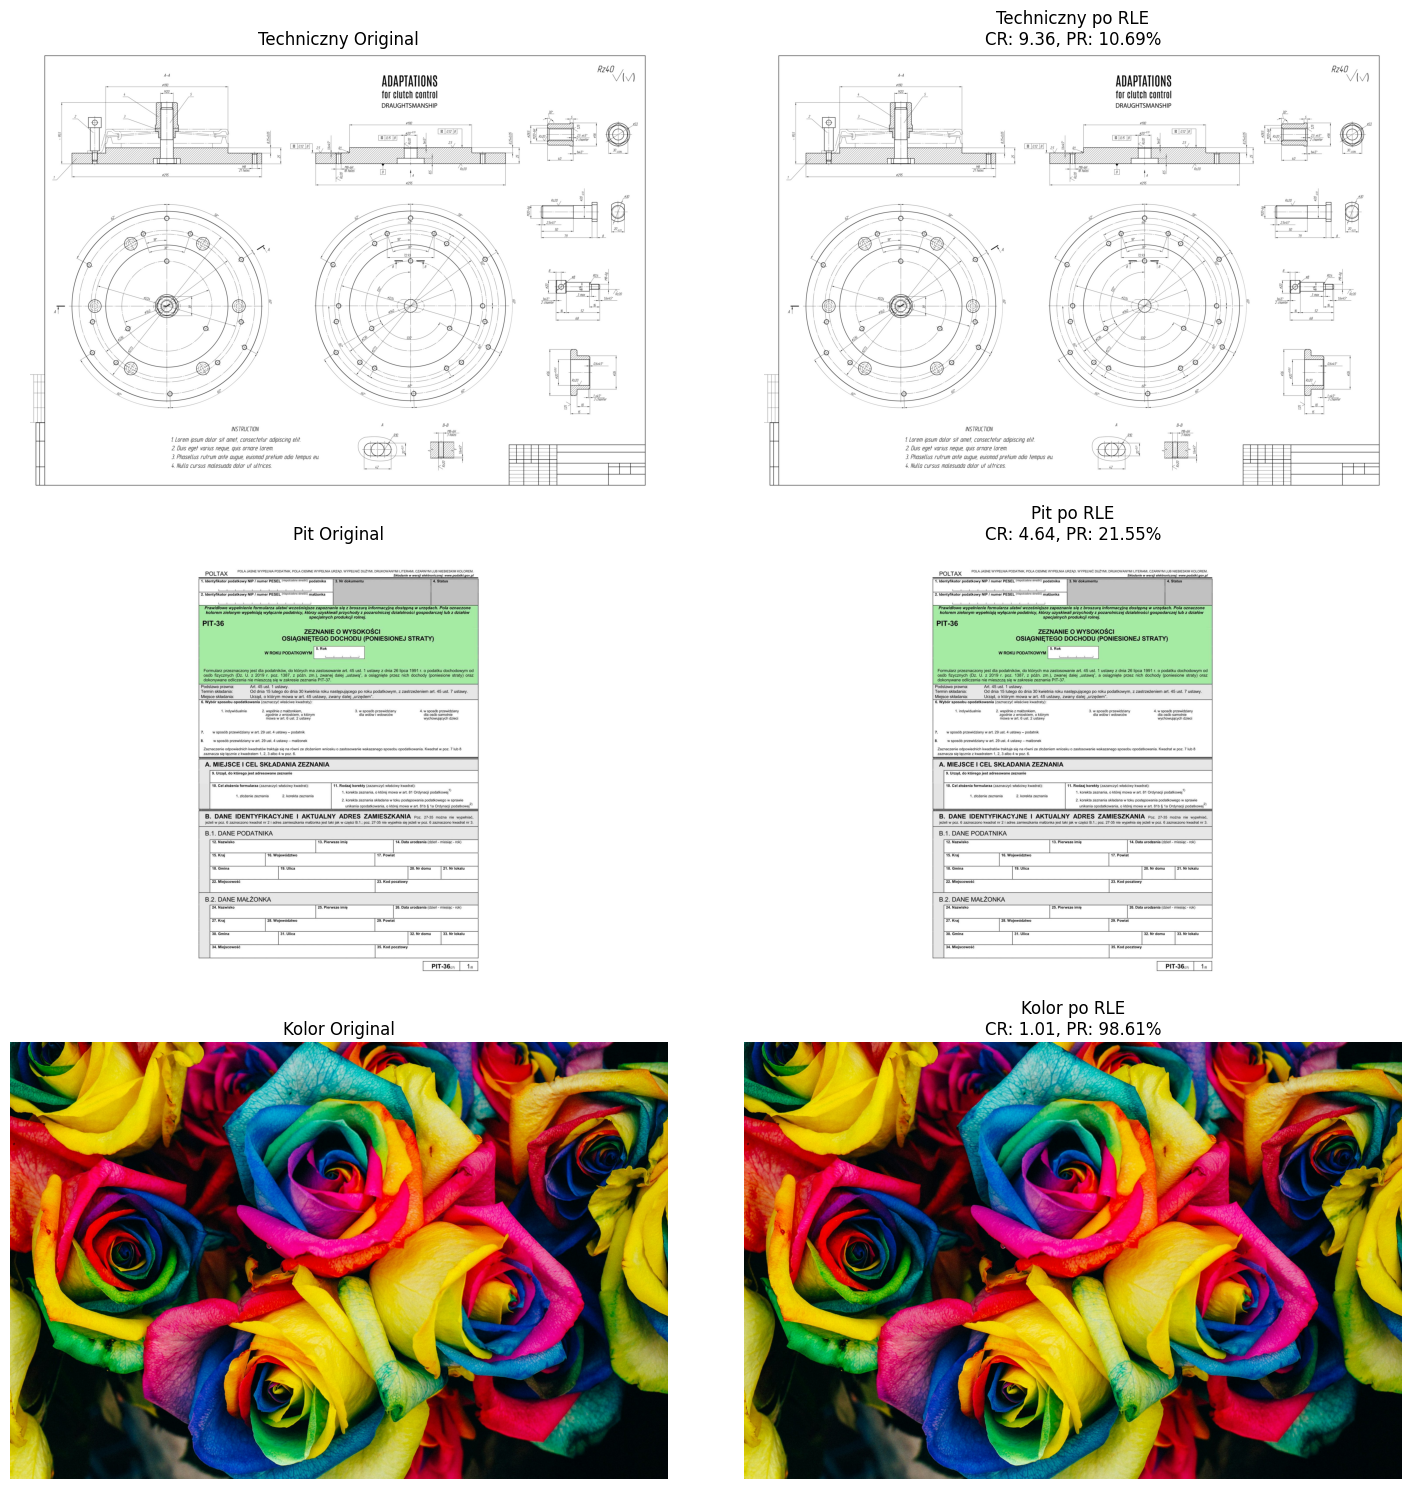

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Pierwszy obraz
img1 = plt.imread('/content/techniczny.jpg')
img1 = img1.astype(int)
compressed1, og_shape1 = RLE_encode(img1)
CR1 = get_size(img1) / get_size(compressed1)
PR1 = get_size(compressed1) / get_size(img1) * 100
test2_1 = RLE_decode(compressed1, og_shape1)
test2_1 = test2_1.astype(int)

# Obraz przed kompresją
axes[0, 0].imshow(img1, cmap='gray')
axes[0, 0].set_title(f"Techniczny Original")
axes[0, 0].axis('off')

# Obraz po kompresji i odkompresowaniu
axes[0, 1].imshow(test2_1, cmap='gray')
axes[0, 1].set_title(f"Techniczny po RLE\nCR: {CR1:.2f}, PR: {PR1:.2f}%")
axes[0, 1].axis('off')

# Drugi obraz
img2 = plt.imread('/content/pit.jpg')
img2 = img2.astype(int)
compressed2, og_shape2 = RLE_encode(img2)
CR2 = get_size(img2) / get_size(compressed2)
PR2 = get_size(compressed2) / get_size(img2) * 100
test2_2 = RLE_decode(compressed2, og_shape2)
test2_2 = test2_2.astype(int)

# Obraz przed kompresją
axes[1, 0].imshow(img2)
axes[1, 0].set_title(f"Pit Original")
axes[1, 0].axis('off')

# Obraz po kompresji i odkompresowaniu
axes[1, 1].imshow(test2_2)
axes[1, 1].set_title(f"Pit po RLE\nCR: {CR2:.2f}, PR: {PR2:.2f}%")
axes[1, 1].axis('off')

# Trzeci obraz
img3 = plt.imread('/content/kolor.jpg')
img3 = img3.astype(int)
compressed3, og_shape3 = RLE_encode(img3)
CR3 = get_size(img3) / get_size(compressed3)
PR3 = get_size(compressed3) / get_size(img3) * 100
test2_3 = RLE_decode(compressed3, og_shape3)
test2_3 = test2_3.astype(int)

# Obraz przed kompresją
axes[2, 0].imshow(img3)
axes[2, 0].set_title(f"Kolor Original")
axes[2, 0].axis('off')

# Obraz po kompresji i odkompresowaniu
axes[2, 1].imshow(test2_3)
axes[2, 1].set_title(f"Kolor po RLE\nCR: {CR3:.2f}, PR: {PR3:.2f}%")
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

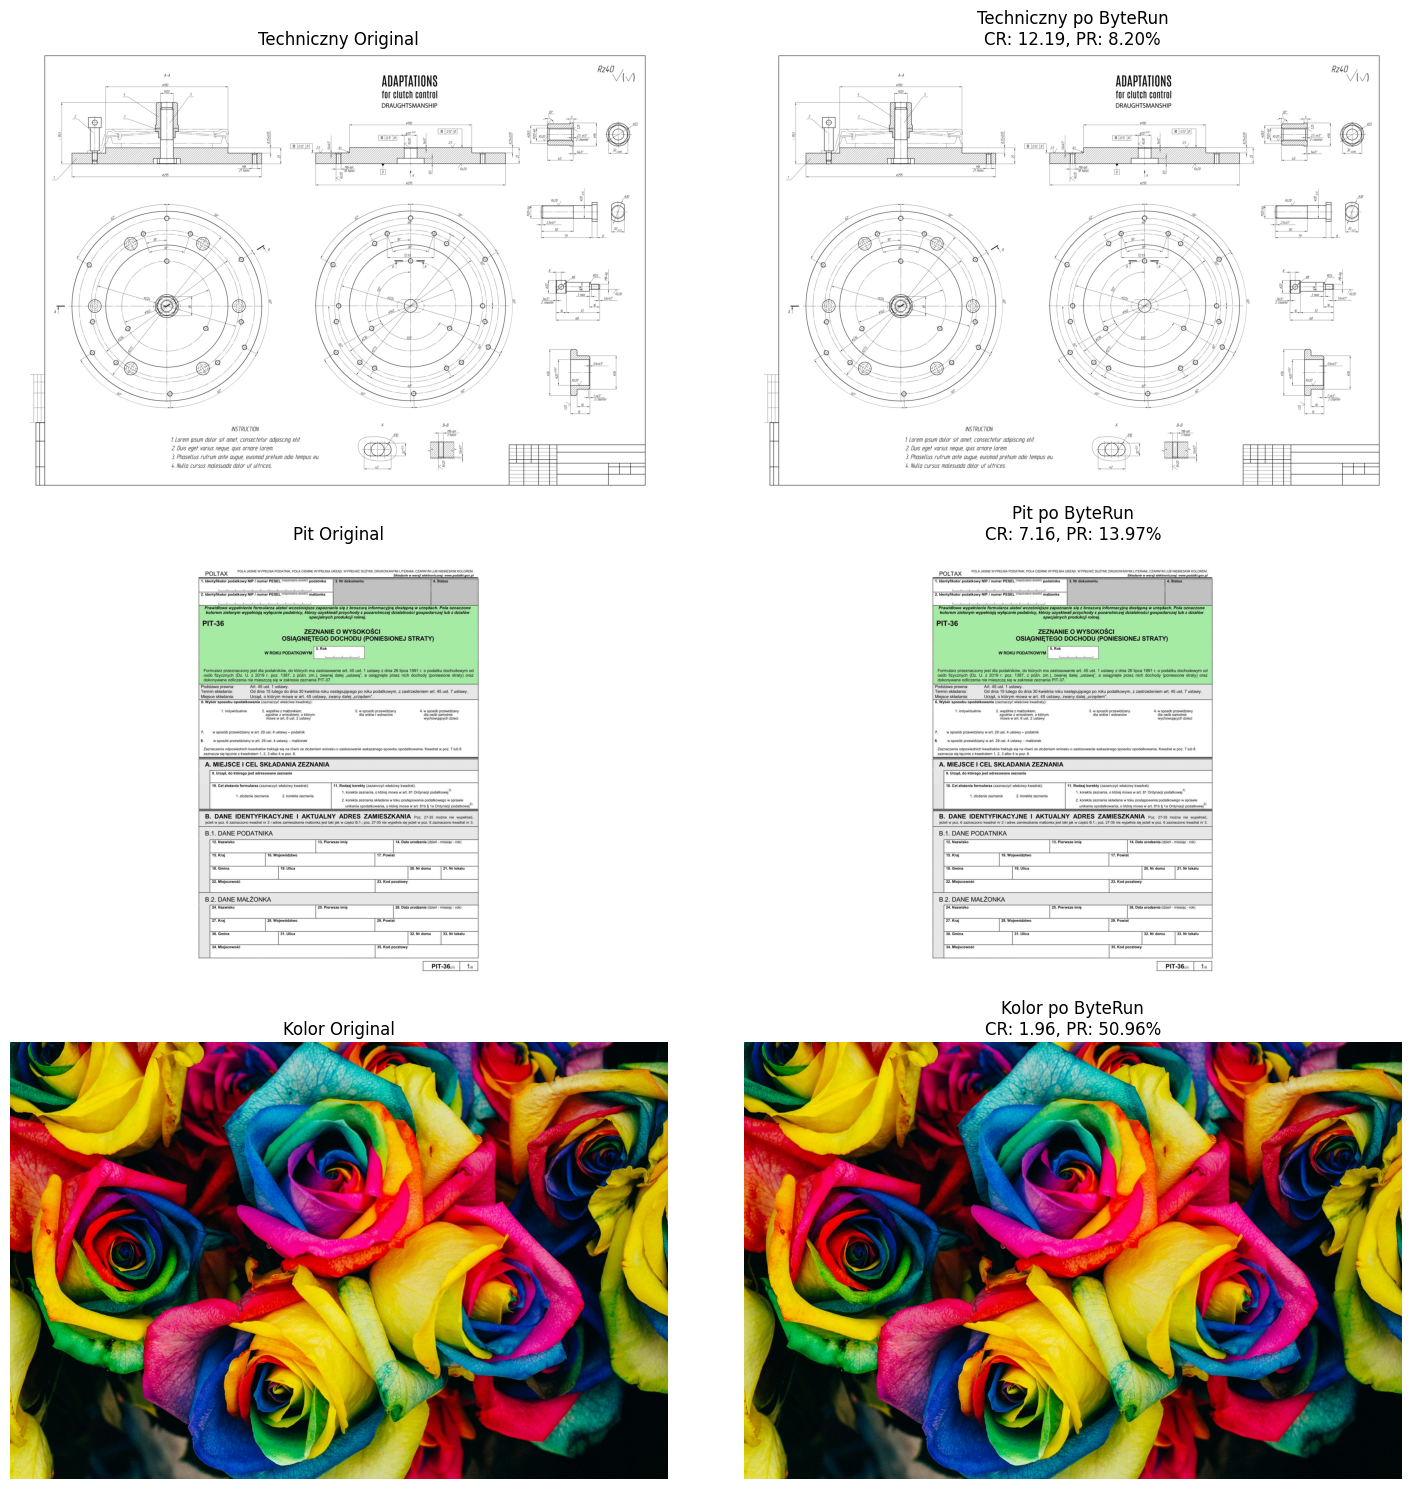

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Pierwszy obraz
img1 = plt.imread('/content/techniczny.jpg')
img1 = img1.astype(int)
compressed1, og_shape1 = ByteRun_encode(img1)
CR1 = get_size(img1) / get_size(compressed1)
PR1 = get_size(compressed1) / get_size(img1) * 100
test2_1 = ByteRun_decode(compressed1, og_shape1)
test2_1 = test2_1.astype(int)

# Obraz przed kompresją
axes[0, 0].imshow(img1, cmap='gray')
axes[0, 0].set_title(f"Techniczny Original")
axes[0, 0].axis('off')

# Obraz po kompresji i odkompresowaniu
axes[0, 1].imshow(test2_1, cmap='gray')
axes[0, 1].set_title(f"Techniczny po ByteRun\nCR: {CR1:.2f}, PR: {PR1:.2f}%")
axes[0, 1].axis('off')

# Drugi obraz
img2 = plt.imread('/content/pit.jpg')
img2 = img2.astype(int)
compressed2, og_shape2 = ByteRun_encode(img2)
CR2 = get_size(img2) / get_size(compressed2)
PR2 = get_size(compressed2) / get_size(img2) * 100
test2_2 = ByteRun_decode(compressed2, og_shape2)
test2_2 = test2_2.astype(int)

# Obraz przed kompresją
axes[1, 0].imshow(img2)
axes[1, 0].set_title(f"Pit Original")
axes[1, 0].axis('off')

# Obraz po kompresji i odkompresowaniu
axes[1, 1].imshow(test2_2)
axes[1, 1].set_title(f"Pit po ByteRun\nCR: {CR2:.2f}, PR: {PR2:.2f}%")
axes[1, 1].axis('off')

# Trzeci obraz
img3 = plt.imread('/content/kolor.jpg')
img3 = img3.astype(int)
compressed3, og_shape3 = ByteRun_encode(img3)
CR3 = get_size(img3) / get_size(compressed3)
PR3 = get_size(compressed3) / get_size(img3) * 100
test2_3 = ByteRun_decode(compressed3, og_shape3)
test2_3 = test2_3.astype(int)

# Obraz przed kompresją
axes[2, 0].imshow(img3)
axes[2, 0].set_title(f"Kolor Original")
axes[2, 0].axis('off')

# Obraz po kompresji i odkompresowaniu
axes[2, 1].imshow(test2_3)
axes[2, 1].set_title(f"Kolor po ByteRun\nCR: {CR3:.2f}, PR: {PR3:.2f}%")
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()